In [16]:
import warnings
import sys
import multiprocessing
import networkx as nx
from sklearn.model_selection import ParameterGrid
from matplotlib import pyplot as plt
import time
import os
import seaborn as sns

import warnings 
warnings.filterwarnings("ignore")

from ABM_Func import *

In [2]:
from input_parameters import *

In [11]:
# # New Parallelization Package
# from mpi4py import MPI
# #Retrieves MPI environment
# comm = MPI.COMM_WORLD
# #set variable "size" as the total number of MPI processes
# size = comm.Get_size()
# #print(size)
# #set variable "rank" as the specific MPI rank on each MPI process
# rank = comm.Get_rank()

In [28]:
import random

landscapes = [[75,75,5]]
myopia = False

num_agents = 16
num_searches = 10
num_graphs = 1
num_sims = 1
distance_costs = [0]
edges = [15,120]
# edges = list(range(119,120))


memory=[ [(16,25)] ]

In [29]:
# Exception graph construction for single agents
if num_agents == 1:

    graphs = [nx.Graph() for _ in range(num_graphs)]
    for graph in graphs:
        graph.add_node(1)

    graph_labels = dict(zip(graphs, range(len(graphs)))) 

# Create graph/graphs for multiple agents
elif num_agents > 1:

    graphs = []     
    if len(edges) != 1:
        for edge in edges:
            graphs.append([nx.gnm_random_graph(num_agents, edge) for _ in range(num_graphs)])
        graphs = [graph[i] for graph in graphs for i in range(len(graph))] 
        
    graph_labels = dict(zip(graphs, range(len(graphs)))) 

In [30]:
# Create Parameter Grid
parameter_grid = {'landscape': landscapes, 
                'num_agents': [num_agents], 
                'num_searches': [num_searches], 
                'graph': graphs, 
                'memory': memory,
                'distance_costs': distance_costs,
                'myopia': [myopia],
                'sync': [True]}

# Create Parameter Space
parameter_combos = list(ParameterGrid(parameter_grid))
parameter_combos = [a.copy() for a in parameter_combos for _ in range(num_sims)]

# Labels Param_Combos with IDs for Identification
for i, pcombo in enumerate(parameter_combos):
    # Add id key
    pcombo.update({'id': i})
    # Add graph_label key
    pcombo.update({'graph_label': graph_labels[pcombo['graph']]})

#Shuffle so batches aren't unbalanced
random.shuffle(parameter_combos)

In [16]:
# size = 10

## Split Parameter Space for Distribution
# split_seeds = np.array_split(parameter_combos, size, axis=0)

# p_combo = split_seeds[0][0]

In [31]:
sim_hist = []
for p_combo in parameter_combos:
    start = time.time()
    sim_hist.append(run_model(p_combo))
    print(f'Time Taken: {round(time.time()-start,0)} seconds!')

Population initialized!
Sim Complete!
Time Taken: 63.0 seconds!
Population initialized!
Sim Complete!
Time Taken: 187.0 seconds!


In [88]:
sim_index = []
step_index = []
avg_value = []
search_costs_= []
memories = []
densities_ = []
ls_params_ = []
pop_ids_ = []
graph_ids_ = []

for i, pop in enumerate(sim_hist):

    # filename_ = f'./{folder_}/landscapes/'
    # pop.landscape.tofile(f'{filename_}{pop.id_}_landscape.csv', sep=',')

    for j in range(pop.num_searches+1):

        # Sim + Step Indices
        #sim_index.append(f'{rank}_{i+1}')
        step_index.append(j)

        # Average Agent Value at each Step
#         agent_vals = []
#         for agent in pop.agents:
#             agent_vals.append(agent.search_hist['Value'][j])
#         avg_value.append((sum(agent_vals) / len(agent_vals)))
        avg_value.append(np.mean(pop.report_step_averages(j)))

        # Agent Properties
        search_costs_.append(pop.distance_cost)
        memories.append(pop.memory[0])

        # Graph Properties
#         densities_.append(pop.graphdensity)
        densities_.append(nx.density(pop.graph))

        # IDs
#         ls_params_.append(pop.ls_params)
        pop_ids_.append(pop.id_)
#         graph_ids_.append(pop.graph_id)

data = {#'Sim_ID': sim_index, 
        'Step': step_index, 
        'AVG_Value': avg_value, 
        'Search_Cost': search_costs_,
        'Memory': memories,
        'Densities': densities_,
#         'LS_Params': ls_params_
        #'Pop_IDs': pop_ids_,
        #'Graph_IDs': graph_ids_
        }


df = pd.DataFrame(data)

In [93]:
df.head()

,Step,AVG_Value,Search_Cost,Memory,Densities
0,0,0.533454,0,25,0.125
1,1,0.494023,0,25,0.125
2,2,0.533635,0,25,0.125
3,3,0.466379,0,25,0.125
4,4,0.441857,0,25,0.125


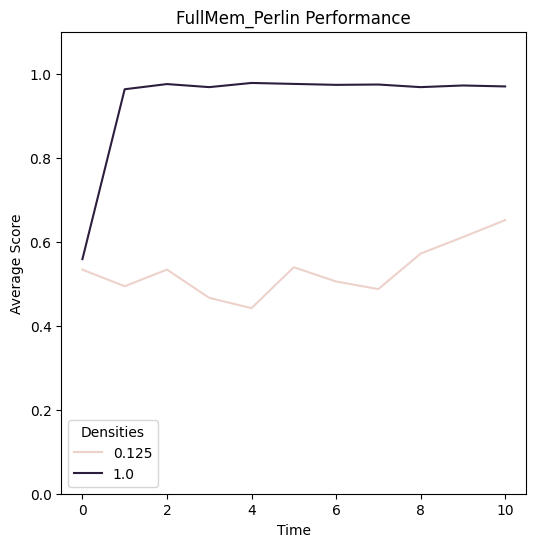

<Figure size 640x480 with 0 Axes>

In [92]:
plt.figure(figsize=(6,6))

sns.lineplot(data=df, x='Step', y='AVG_Value', hue='Densities')

plt.ylim(0,1.1)

plt.xlabel('Time')
plt.ylabel('Average Score')

plt.title(f'FullMem_Perlin Performance')
# plt.savefig(f'Outputs/Comp16_100_LS[17,5]_Mem[2,25]Perf.jpg')

plt.show()
plt.clf()

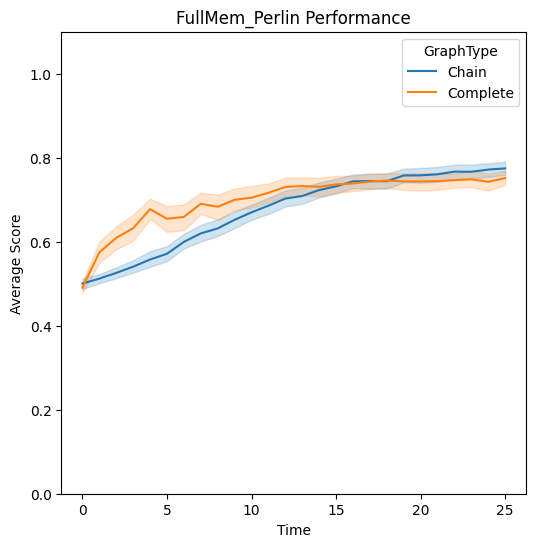

<Figure size 640x480 with 0 Axes>

In [87]:
df = pd.read_csv('fullmem_perlin_performance.csv')
df['GraphType'] = np.where(df['Densities']==1.000, 'Complete', 'Chain')

plt.figure(figsize=(6,6))

sns.lineplot(data=df, x='Step_Index', y='AVG_Value', hue='GraphType')

plt.ylim(0,1.1)

plt.xlabel('Time')
plt.ylabel('Average Score')

plt.title(f'FullMem_Perlin Performance')
# plt.savefig(f'Outputs/Comp16_100_LS[17,5]_Mem[2,25]Perf.jpg')

plt.show()
plt.clf()

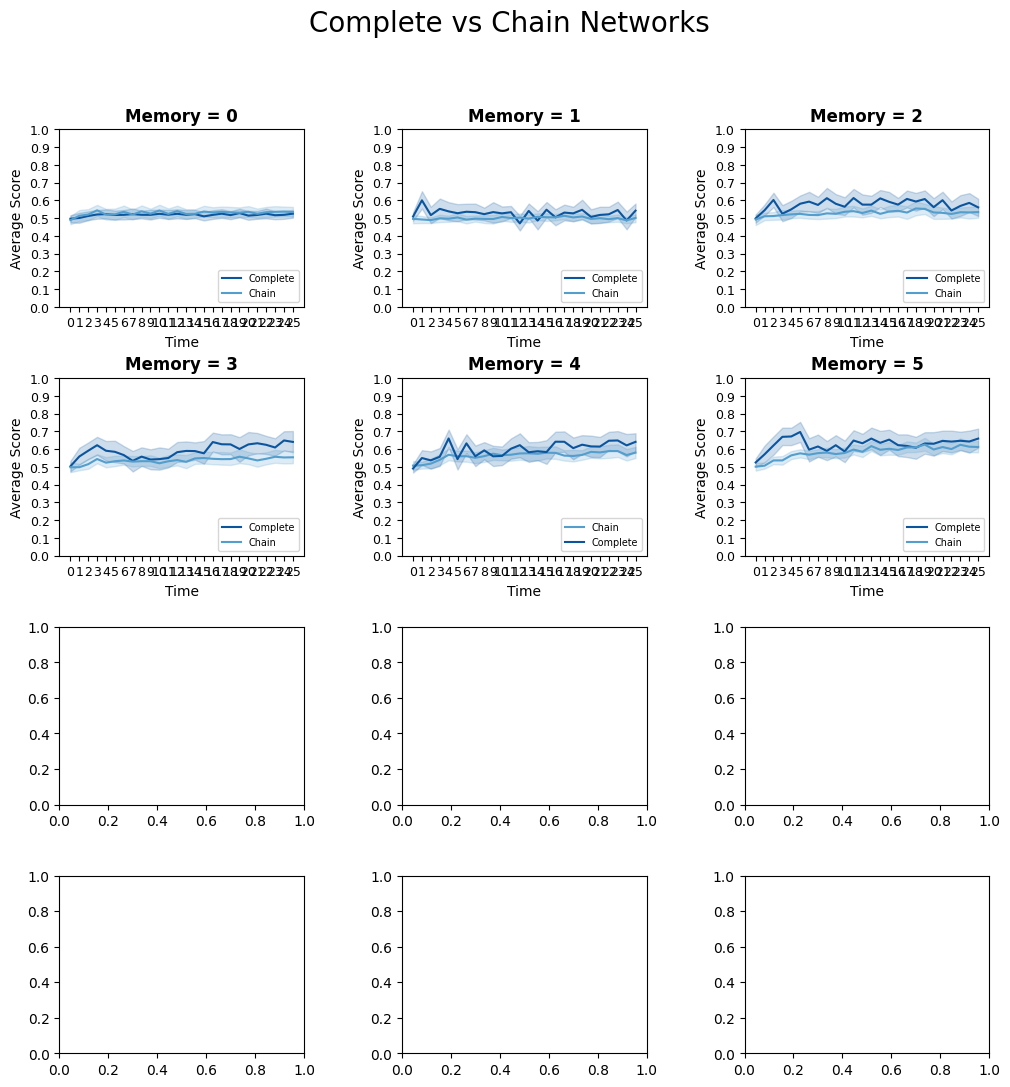

In [80]:
df = pd.read_csv('partialmem_25_perlin_performance.csv')
df['GraphType'] = np.where(df['Densities']==1.000, 'Complete', 'Chain')

palette_colors = [sns.color_palette('Blues')[3], sns.color_palette('Blues')[5]]
graph_types = ['Chain', 'Complete']
palette_dict = {graph: color for graph, color in zip(graph_types, palette_colors)}

fig, axes = plt.subplots(4,3, figsize=(12,12))
xlabels = [a for a in range(0,26)]
ylabels = [a/10 for a in range(0,11)]

scs = sorted(df['Memory'].unique())

for i in range(len(scs)):
    temp=df[df['Memory']==scs[i]].copy()
    
    sns.lineplot(ax=axes.flat[i],data=temp,x='Step_Index',y='AVG_Value',hue='GraphType', palette=palette_dict)
    axes.flat[i].set_title(f'Memory = {scs[i]}', fontweight='bold')
    axes.flat[i].legend(fontsize='x-small',loc='lower right')    
    
    axes.flat[i].set_ylim(0,1)
    axes.flat[i].set_xticks(xlabels, labels=xlabels, fontsize=9)
    axes.flat[i].set_yticks(ylabels, labels=ylabels, fontsize=9)

    axes.flat[i].set_ylabel('Average Score',fontsize=10)
    axes.flat[i].set_xlabel('Time', fontsize=10)
    
plt.subplots_adjust(wspace=0.4,hspace=0.4)
fig.suptitle('Complete vs Chain Networks', fontsize=20)

# plt.savefig(f'Outputs/CompPerfAll_16_100_Cap25.jpg')
plt.show()